In [281]:
"""
------------------------------------------------------------------------------
Libraries
------------------------------------------------------------------------------
"""

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

In [282]:
"""
------------------------------------------------------------------------------
Load GeoJson files
------------------------------------------------------------------------------
"""

admin_areas = gpd.read_file("../data/raw/Prognoseräume.json")

"""
 more about the data in the README
"""
cannabis = gpd.read_file("../data/raw/Cannabis.geojson")

In [283]:
cannabis.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,abandoned,access,access:covid19,addr:city,addr:country,...,wheelchair:description:de,wheelchair:step_height,wikidata,wikimedia_commons,@relations,wikipedia,winter_service,year,youtube,geometry
0,relation/4178,relation/4178,None,None,None,None,None,None,Berlin,DE,...,None,None,Q15058360,None,None,de:Paracelsus-Bad,None,None,None,"POLYGON ((13.3466 52.57539, 13.34656 52.5754, ..."
1,relation/7127,relation/7127,None,None,None,None,None,None,None,None,...,None,None,Q1503434,None,None,de:Georg-Schlesinger-Schule,None,None,None,"POLYGON ((13.37054 52.5626, 13.37052 52.5626, ..."
2,relation/22529,relation/22529,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((13.3432 52.52203, 13.34322 52.52184,..."
3,relation/27716,relation/27716,None,None,None,None,None,None,Berlin,DE,...,None,None,Q32653621,None,None,None,None,None,None,"POLYGON ((13.43234 52.53413, 13.43257 52.53402..."
4,relation/31076,relation/31076,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((13.32116 52.49633, 13.32109 52.49595..."


In [284]:
"""
------------------------------------------------------------------------------
Data exploration
------------------------------------------------------------------------------
"""

cannabis.columns

Index(['id', '@id', 'TMC:cid_58:tabcd_1:Class',
       'TMC:cid_58:tabcd_1:LCLversion', 'TMC:cid_58:tabcd_1:LocationCode',
       'abandoned', 'access', 'access:covid19', 'addr:city', 'addr:country',
       ...
       'wheelchair:description:de', 'wheelchair:step_height', 'wikidata',
       'wikimedia_commons', '@relations', 'wikipedia', 'winter_service',
       'year', 'youtube', 'geometry'],
      dtype='object', length=469)

In [285]:
cannabis.shape

(17031, 469)

In [286]:
"""
------------------------------------------------------------------------------
CSR (coordinate reference system)
------------------------------------------------------------------------------
"""

#Check CRS
print(admin_areas.crs)
print(cannabis.crs)

EPSG:4326
EPSG:4326


In [287]:
cannabis = cannabis.to_crs(epsg=25833)

In [288]:
"""
------------------------------------------------------------------------------
Checking invalid geometries
------------------------------------------------------------------------------
"""

#Check the combined dataframe for empty or invalid geometries
print(f"Leere Geometrien in cannabis: {len(cannabis[cannabis.is_empty])}")
print(f"Ungültige Geometrien in cannabis: {len(cannabis[~cannabis.is_valid])}")

Leere Geometrien in cannabis: 0
Ungültige Geometrien in cannabis: 2


In [289]:
# Fix invalid geometries by applying a zero-width buffer
cannabis["geometry"] = cannabis["geometry"].buffer(0)

In [290]:
print(f"Ungültige Geometrien in cannabis: {len(cannabis[~cannabis.is_valid])}")

Ungültige Geometrien in cannabis: 0


In [291]:
#100m around Kitas, Schools, Youth centre, Playgrounds and Sports pitches

cannabis["geometry_100"] = cannabis["geometry"].buffer(100)

df_Cannabis = cannabis.drop(columns="geometry")
df_Cannabis = df_Cannabis.set_geometry("geometry_100")

df_Cannabis.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,abandoned,access,access:covid19,addr:city,addr:country,...,wheelchair:description:de,wheelchair:step_height,wikidata,wikimedia_commons,@relations,wikipedia,winter_service,year,youtube,geometry_100
0,relation/4178,relation/4178,None,None,None,None,None,None,Berlin,DE,...,None,None,Q15058360,None,None,de:Paracelsus-Bad,None,None,None,"POLYGON ((387853.402 5826323.56, 387853.876 58..."
1,relation/7127,relation/7127,None,None,None,None,None,None,None,None,...,None,None,Q1503434,None,None,de:Georg-Schlesinger-Schule,None,None,None,"POLYGON ((389473.74 5824607.431, 389465.915 58..."
2,relation/22529,relation/22529,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((387491.585 5820385.724, 387491.453 5..."
3,relation/27716,relation/27716,None,None,None,None,None,None,Berlin,DE,...,None,None,Q32653621,None,None,None,None,None,None,"POLYGON ((393606.719 5821524.077, 393599.303 5..."
4,relation/31076,relation/31076,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((385930.726 5817581.095, 385932.459 5..."


In [292]:
#Ensure both GeoDataFrames have the same CRS (epsg=25833)
if df_Cannabis.crs != admin_areas.crs:
    admin_areas = admin_areas.to_crs(df_Cannabis.crs)

In [293]:
#Check CRS
print(admin_areas.crs)
print(df_Cannabis.crs)

EPSG:25833
EPSG:25833


<Axes: >

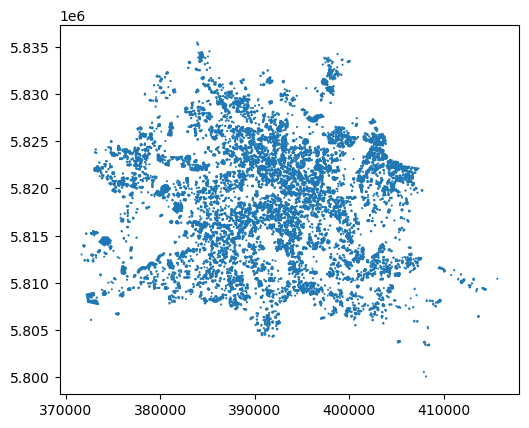

In [294]:
df_Cannabis.plot()

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_6958/921177826.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


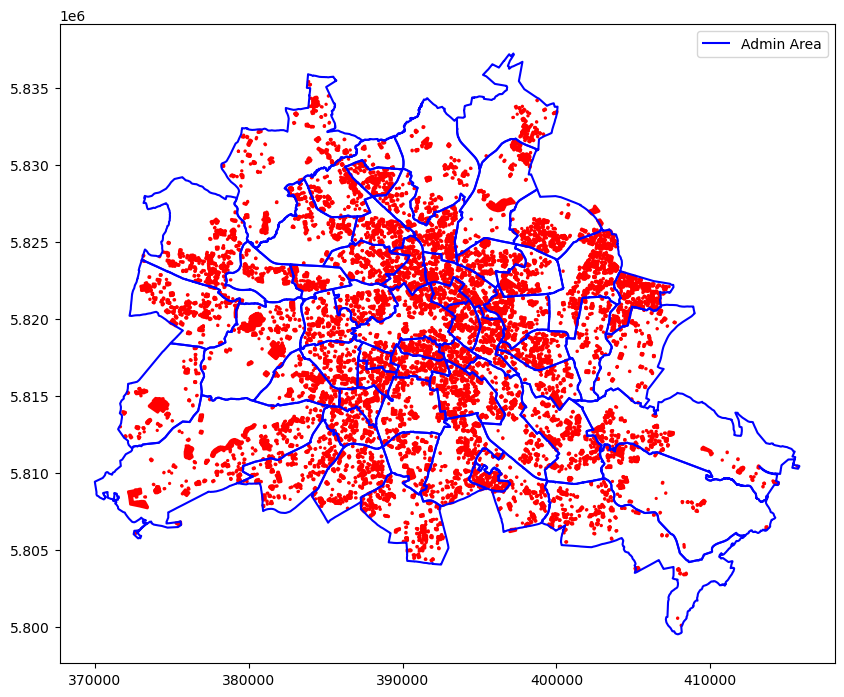

In [295]:
#Test plot
fig, ax = plt.subplots(figsize=(10,10))
admin_areas.boundary.plot(ax=ax, color="blue", label="Admin Area")
df_Cannabis.plot(ax=ax, color="red", markersize=5, label="cannabis free")
plt.legend()
plt.show()

In [296]:
# check for one admin area
geometry_union = df_Cannabis["geometry_100"].union_all()

intersections = geometry_union.intersection(admin_areas.iloc[0].geometry) 

print(intersections)

Cannabis_free_m2 = intersections.area

MULTIPOLYGON (((393202.4338074237 5822418.888937956, 393208.8214484195 5822411.765019048, 393214.4989925694 5822404.063222471, 393219.41446072026 5822395.854059848, 393223.5228506904 5822387.212687853, 393226.78654927487 5822378.218220129, 393229.1756766023 5822368.953002986, 393229.5087645628 5822366.844007806, 393232.7639737277 5822369.608149721, 393240.89279402193 5822375.230668573, 393249.5369510707 5822380.023265626, 393258.6119997256 5822383.939121792, 393268.0292854391 5822386.9399829, 393277.69681033504 5822388.996533408, 393287.5201319396 5822390.088682782, 393297.4032857942 5822390.205761768, 393307.24972293625 5822389.346626617, 393316.96325309057 5822387.5196702555, 393326.44898435596 5822384.742740303, 393335.61425020854 5822381.042964708, 393344.369514765 5822376.45648674, 393345.0614298162 5822376.04923264, 393345.70382797084 5822376.048287208, 393355.52815616754 5822375.060076474, 393365.207137722 5822373.107821101, 393374.646408386 5822370.210554406, 393383.7539409484 

In [297]:
Cannabis_free_m2 = intersections.area

print(Cannabis_free_m2)

2265345.4071518704


In [298]:
df_Cannabis.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,abandoned,access,access:covid19,addr:city,addr:country,...,wheelchair:description:de,wheelchair:step_height,wikidata,wikimedia_commons,@relations,wikipedia,winter_service,year,youtube,geometry_100
0,relation/4178,relation/4178,None,None,None,None,None,None,Berlin,DE,...,None,None,Q15058360,None,None,de:Paracelsus-Bad,None,None,None,"POLYGON ((387853.402 5826323.56, 387853.876 58..."
1,relation/7127,relation/7127,None,None,None,None,None,None,None,None,...,None,None,Q1503434,None,None,de:Georg-Schlesinger-Schule,None,None,None,"POLYGON ((389473.74 5824607.431, 389465.915 58..."
2,relation/22529,relation/22529,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((387491.585 5820385.724, 387491.453 5..."
3,relation/27716,relation/27716,None,None,None,None,None,None,Berlin,DE,...,None,None,Q32653621,None,None,None,None,None,None,"POLYGON ((393606.719 5821524.077, 393599.303 5..."
4,relation/31076,relation/31076,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((385930.726 5817581.095, 385932.459 5..."


In [299]:
"""
------------------------------------------------------------------------------
Function
airquality by admin area
Mean no2
------------------------------------------------------------------------------
"""


def calculate_intersection_area(admin_area, df_Cannabis):

    #unite all cannabis free areas to prevent double counting of overlapping areas
    geometry_union = df_Cannabis["geometry_100"].union_all()
    #find intersections between the geometry_union and admin areas
    intersections = geometry_union.intersection(admin_area.geometry)
     
    #calculate total area, .sum() not needed
    Cannabis_free_m2 = int(intersections.area if not intersections.is_empty else 0)
    
    #admin areas in m2
    admin_area_m2 = admin_area.geometry.area
    
    #Percent
    Cannabis_free_perc = round(((Cannabis_free_m2 / admin_area_m2) * 100), 1)
    
    print(f"Admin Area: {admin_area.pgr_name}, Admin_area in m²: {admin_area_m2}, Cannabis free area in m²: {Cannabis_free_m2}, Cannabis_free_perc: {Cannabis_free_perc}%")
    
    return Cannabis_free_m2, Cannabis_free_perc

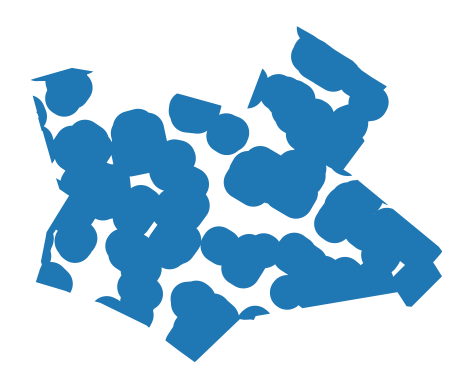

In [301]:
# #Cannabis free area svg
# geometry_union = df_Cannabis["geometry_100"].union_all()

# intersections_cannabis = geometry_union.intersection(admin_areas.iloc[0].geometry)

# gdf_intersections_cannabis = gpd.GeoDataFrame(geometry=[intersections_cannabis], crs=admin_areas.crs) #single geometry, it is converted into a GeoDataFrame before it is plotted

# fig, ax = plt.subplots()
# gdf_intersections_cannabis.plot(ax=ax)
# ax.set_axis_off()

# fig.savefig("intersections_cannabis_1.svg", format="svg")

In [327]:
#example intersection geojson
intersections_cannabis = geometry_union.intersection(admin_areas.iloc[0].geometry)
gdf_intersections_cannabis = gpd.GeoDataFrame(geometry=[intersections_cannabis], crs=admin_areas.crs)
gdf_intersections_cannabis = gdf_intersections_cannabis.to_crs(epsg=4326)

gdf_intersections_cannabis.to_file("intersections_cannabis_adminArea1.geojson")


In [328]:
#Calculation of Cannabis_free_m2 and percent for each administrative area
admin_areas[["Cannabis_free_m2","Cannabis_free_perc"]] = admin_areas.apply(
    lambda row: calculate_intersection_area(row, df_Cannabis), axis=1, result_type="expand" #result_type="expand" is a useful parameter that ensures that multiple return values from a function are placed in separate columns of a DataFrame
)

Admin Area: Südlicher Prenzlauer Berg, Admin_area in m²: 3029500.5378611204, Cannabis free area in m²: 2265345, Cannabis_free_perc: 74.8%
Admin Area: Kreuzberg Süd, Admin_area in m²: 4743826.165386829, Cannabis free area in m²: 3133298, Cannabis_free_perc: 66.1%
Admin Area: Marienfelde / Lichtenrade, Admin_area in m²: 19182608.505854674, Cannabis free area in m²: 5929822, Cannabis_free_perc: 30.9%
Admin Area: Wilhelmstadt / Staaken, Admin_area in m²: 23005236.730588343, Cannabis free area in m²: 6240512, Cannabis_free_perc: 27.1%
Admin Area: Nördliches Weißensee, Admin_area in m²: 22213197.03904734, Cannabis free area in m²: 3781349, Cannabis_free_perc: 17.0%
Admin Area: Tempelhof, Admin_area in m²: 13662083.310133565, Cannabis free area in m²: 3908259, Cannabis_free_perc: 28.6%
Admin Area: Lichtenberg Nord, Admin_area in m²: 9535797.673239538, Cannabis free area in m²: 4783977, Cannabis_free_perc: 50.2%
Admin Area: Lichtenberg Mitte, Admin_area in m²: 7585331.205532642, Cannabis free 

In [329]:
#Data frame
df_Cannabis_freeZone = admin_areas[["pgr_id", "pgr_name", "Cannabis_free_m2", "Cannabis_free_perc"]]
#sort values descending
df_Cannabis_freeZone.sort_values(by="Cannabis_free_perc", ascending=False, inplace=True)
df_Cannabis_freeZone.reset_index(drop=True, inplace=True)

df_Cannabis_freeZone["Cannabis_free_m2"] = df_Cannabis_freeZone["Cannabis_free_m2"].astype(int)
df_Cannabis_freeZone

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_6958/672581344.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Cannabis_freeZone.sort_values(by="Cannabis_free_perc", ascending=False, inplace=True)
/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_6958/672581344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Cannabis_freeZone["Cannabis_free_m2"] = df_Cannabis_freeZone["Cannabis_free_m2"].astype(int)


,pgr_id,pgr_name,Cannabis_free_m2,Cannabis_free_perc
0,0830,Gropiusstadt,2146826,80.8
1,0230,Kreuzberg Ost,2128478,77.1
2,0210,Kreuzberg Nord,2258290,76.8
3,1020,Hellersdorf,6116720,75.3
4,0370,Südlicher Prenzlauer Berg,2265345,74.8
5,0130,Gesundbrunnen,4251517,74.8
6,0720,Schöneberg Süd,2254763,67.2
7,0220,Kreuzberg Süd,3133298,66.1
8,0360,Nördlicher Prenzlauer Berg,5296290,65.9
9,1260,Märkisches Viertel,3058207,64.0


In [330]:
#CSV
df_Cannabis_freeZone.to_csv("Cannabis_freeArea_byAdminArea.csv", index=False)